In [80]:
!pip install ipygee

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 1.8 MB/s eta 0:00:00
  Created wheel for ipygee: filename=ipygee-0.0.18-py3-none-any.whl size=41208 sha256=f5280d1a581f4e4914b36e38ca0872f3e0894597c3620879d156e80dae675643
  Stored in directory: /Users/terriblepollo/Library/Caches/pip/wheels/9a/d4/84/b0fd286116c8ebb4632ac91e22224346066ff1fe1f3ca9073e
  Created wheel for geetools: filename=geetools-0.6.14-py3-none-any.whl size=92090 sha256=d2aef2c232c7868ccf08acb689f1b688a5ae586e4e5caf74d536ac4139963a24
  Stored in directory: /Users/terriblepollo/Library/Caches/pip/wheels/20/4c/bf/0228d788d820ac3cf05cbaa753965eb6396b5d3fe11ed912e5
Successfully built ipygee geetools


## 1. Importaciones y lecturas

In [101]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ee
import geemap
from shapely.geometry import box
import ipygee as ui
import numpy as np
import seaborn as sns

In [37]:
# ee.Authenticate()
ee.Initialize()

In [38]:
big_crimes = gpd.read_file('NYPD_violence_against_women.gpkg')
big_crimes.to_crs('EPSG:4326', inplace=True)

In [39]:
manz = gpd.read_file('nyct2020_23b/nyct2020.shp')
manz.to_crs('EPSG:4326', inplace=True)
manz.head(1)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,PUMA,Shape_Leng,Shape_Area,geometry
0,1,1,Manhattan,000100,1000100,None,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,4121,10833.043929,1.843005e+06,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."


In [23]:
big_crimes.head(1)

,CMPLNT_FR_DT,OFNS_DESC,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,Latitude,Longitude,year,month,geometry
0,2022-01-07,RAPE,UNKNOWN,BLACK,M,18-24,BLACK,F,40.887314,-73.847272,2022.0,1,POINT (-73.84727 40.88731)


### 1. Importaciones y preprocesamiento

<Axes: >

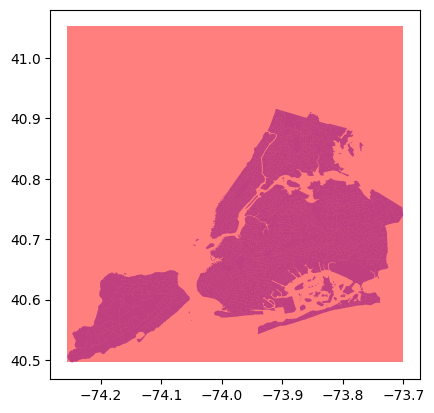

In [42]:
unif = manz.unary_union
bounding_box = unif.bounds
minx, miny, maxx, maxy = bounding_box
width = max(maxx - minx, maxy - miny)
expanded_bbox = box(minx, miny, minx + width, miny + width)
ny_box = gpd.GeoDataFrame(geometry=[expanded_bbox])
ax = manz.plot(color='blue', alpha=0.5)
ny_box.plot(ax=ax, color='red', alpha=0.5)

In [43]:
poly = ny_box.geometry.iloc[0]
xy = list(poly.exterior.coords)
aoi = ee.Geometry.Polygon([xy[0], xy[1], xy[2], xy[3]])
x = aoi.centroid().getInfo()['coordinates'][0]
y = aoi.centroid().getInfo()['coordinates'][1]

In [44]:
aoi2 = ee.Geometry.Point([x-.1, y-.1])

## 2. Visualización de HeatMaps

In [45]:
def cloudMask(image):
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(1 << 3).Or(qa.bitwiseAnd(1 << 4))
    return image.updateMask(mask.Not())


def applyScaleFactors(image):
    thermalband = image.multiply(0.00341802).add(149.0).subtract(273.15)
    return image.addBands(srcImg=thermalband, overwrite=True)

In [46]:
# "LANDSAT/LE07/C01/T1"
# https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC09_C02_T1_L2

collection = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2").filterBounds(aoi).filterDate('2022-05-30', '2022-07-10').map(cloudMask)
filtered_l8 = collection.filter(ee.Filter.lt('CLOUD_COVER', 25))
landsatST = filtered_l8.map(applyScaleFactors)
mean_landsatST = landsatST.mean()
clip_mean_ST = mean_landsatST.clip(aoi)

images=collection.aggregate_array('system:id').getInfo()
print(len(images))

7


In [47]:
Map = geemap.Map()
heat_params = {'min': 15,
    'max': 50,
    'bands': 'ST_B10',
    'palette': ['blue', 'white', 'red']}
Map.addLayer(clip_mean_ST, heat_params, 'ST')
Map.centerObject(aoi2, 10)
Map

Map(center=[40.673871012612906, -74.07780021318202], controls=(WidgetControl(options=['position', 'transparent…

In [60]:
heat_islands = clip_mean_ST.gt(48).selfMask()
hi_params = {'min': 30,
    'max': 50,
    'bands': 'ST_B10',
    'palette': 'black'}
Map.addLayer(heat_islands, hi_params, 'Heat Islands')

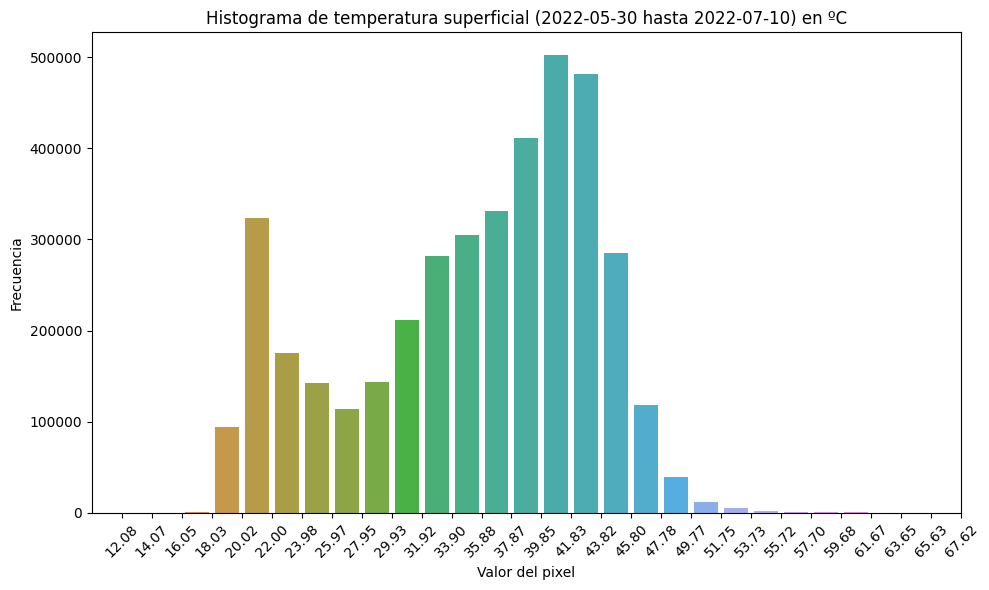

In [123]:
values_ST = clip_mean_ST.select('ST_B10')
histogram_ST = values_ST.reduceRegion(
    reducer=ee.Reducer.histogram(30),
    geometry=aoi,
    scale=30
)

values_ST = clip_mean_ST.select('ST_B10')
histogram_info = histogram_ST.get('ST_B10').getInfo()
histogram_values = histogram_info['histogram']
bucket_means = histogram_info['bucketMeans']

num_bins = len(histogram_values)
min_value = bucket_means[0] - (bucket_means[1] - bucket_means[0]) / 2
max_value = bucket_means[-1] + (bucket_means[-1] - bucket_means[-2]) / 2
bin_edges = np.linspace(min_value, max_value, num_bins + 1)


histogram_df = pd.DataFrame({'bin_edges': bin_edges[:-1], 'histogram_values': histogram_values})


plt.figure(figsize=(10, 6))
ax = sns.barplot(data=histogram_df, x='bin_edges', y='histogram_values')
plt.xlabel('Valor del pixel')
plt.ylabel('Frecuencia')
plt.title('Histograma de temperatura superficial (2022-05-30 hasta 2022-07-10) en ºC')

tick_positions = np.arange(len(bin_edges[:-1])) + 0.5
tick_labels = [f'{val:.2f}' for val in bin_edges[:-1]]
plt.xticks(tick_positions, tick_labels)
plt.xticks(rotation=45)
plt.tight_layout()

In [69]:
statsUrban = clip_mean_ST.reduceRegions(
    collection = collection,
    reducer = ee.Reducer.mean().combine(
        reducer2 = ee.Reducer.minMax(),
        sharedInputs = True
    ),
    scale = 30)

In [14]:
explore_big_crimes = big_crimes.drop('CMPLNT_FR_DT', axis=1)

In [18]:
explore_big_crimes.sample(200).explore()